# Статистический анализ данных. Анализ сервиса аренды самокатов GoFast

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
- без подписки:
 * абонентская плата отсутствует;
 * стоимость одной минуты поездки — 8 рублей;
 * стоимость старта (начала поездки) — 50 рублей;
- с подпиской Ultra
 * абонентская плата — 199 рублей в месяц;
 * стоимость одной минуты поездки — 6 рублей;
 * стоимость старта — бесплатно.

Цель исследования: проверить гипотезы о поведении пользователей и выявить точки роста для компании.


Ход исследования:
1. Выгрузить данные, состоящие трёх таблиц;
2. Провести предобработку данных;
3. Объединить датафреймы в один и разделить пользователей по подпискам;
4. Рассчитать ежемесячную прибыль от каждого пользователя;
5. Проверить статистические гипотезы о поведении пользователей с подпиской и без нее.

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from scipy.stats import binom

## Загрузка данных

In [2]:
users = pd.read_csv('/datasets/users_go.csv')
rides = pd.read_csv('/datasets/rides_go.csv')
subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')

In [3]:
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [5]:
subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [6]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [7]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [8]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


**Вывод:** Данные представляют собой 3 датасета, каждый из которых описывает определенный сегмент данных. Например, users хранит данные о пользователях: имя, возраст, id, тип подписики, город. Таблица subscriptions состоит всего из двух строк - типы подписки. В данных нет пропусков, однако типы данных не везде корректны.

## Предобработка данных

### Приведём тип данных столбца date таблицы rides к типу данных datetype

In [9]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')

In [10]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


Тип данных успешно изменён, теперь можно на основе этих данных составить столбец с номером месяца

### Добавим столбец month к таблице ride

In [11]:
rides['month'] = rides['date'].dt.month

In [12]:
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


In [13]:
rides['date'].dt.year.unique()

array([2021])

Столбец добавлен, данные в нём корректны. Так как поездки были совершены в один год, можно использовать выбранный метод.

### Проверить на дубликаты и обработать их

#### Датасет users

In [14]:
users.duplicated().sum()

31

Итого, в датасете с пользователями 31 явный дубликат. Удалим дублированные строки.

In [15]:
users = users.drop_duplicates().reset_index(drop=True)

In [16]:
users.duplicated().sum()

0

Явные дубликаты в датасете с пользваотелями удалены

#### Датасет rides

In [17]:
rides.duplicated().sum()

0

В датасете нет явных дубликатов, поэтому удаление и обработка не требуется.

#### Датасет subscriptions

In [18]:
subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Явно не содержит дубликатов

**Вывод:** была проведена предобработка данных из датасетов. Изменён тип данных в столбце date таблицы rides на datetime и добавлен столбец month. Также были обработаны дубликаты в таблицах.

## Исследовательский анализ данных

### Исследуем частоту встречаемости городов

In [19]:
users['city'].value_counts()

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

In [20]:
(pd.DataFrame(users['city'].value_counts() / users['city'].count() * 100)
.round(2)
.rename(columns={'city':'Процент города в общей выборке'})
.style.format("{:,.2f}%") 
.background_gradient('coolwarm')
.set_properties(**{'text-align': 'center'})) 

,Процент города в общей выборке
Пятигорск,14.28%
Екатеринбург,13.30%
Ростов-на-Дону,12.91%
Краснодар,12.58%
Сочи,12.32%
Омск,11.93%
Тюмень,11.73%
Москва,10.95%


Всего представлены данные из 8 городов. Половина городов находится на юге страны. Больше всего пользователей в Пятигорске (14,28%), меньше всего - в Москве.

### Соотношение пользователей с подпиской и без подписики

In [21]:
users['subscription_type'].unique()

array(['ultra', 'free'], dtype=object)

<AxesSubplot:title={'center':'Соотношение пользвателей с подпиской и без'}, ylabel='subscription_type'>

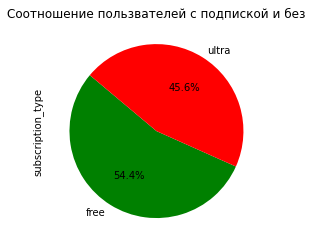

In [22]:
users['subscription_type'].value_counts().plot.pie(autopct='%1.1f%%', 
        startangle=140, colors=['green', 'red'], title='Соотношение пользвателей с подпиской и без')

In [23]:
users['subscription_type'].value_counts()

free     835
ultra    699
Name: subscription_type, dtype: int64

Чуть больше половины пользователей используют сервис без подписки. 

### Возраст пользователей

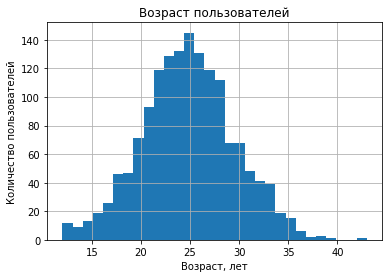

In [24]:
users['age'].hist(bins=30)
plt.title('Возраст пользователей')
plt.xlabel('Возраст, лет')
plt.ylabel('Количество пользователей')
plt.show()

In [25]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Как видно из гистограммы, больше всего пользователей в возрасте 25 лет. Основная масса пользователей имеют возраст от 22 до 28 лет. Есть совсем юные пользователи (12 лет), так и уже солидные (43 года).

### Расстояние, преодолеваемое пользователем за одну поездку

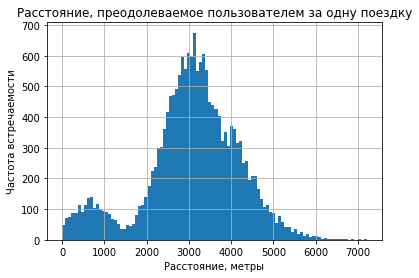

In [26]:
rides['distance'].hist(bins=100)
plt.title('Расстояние, преодолеваемое пользователем за одну поездку')
plt.xlabel('Расстояние, метры')
plt.ylabel('Частота встречаемости')
plt.show()

In [27]:
rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

Из гистограммы и описания видно, что наиболее распространенное расстояние, проезжаемое за поездку, находится в районе 3 км. Большая часть поездок находится в диапазоне от 2,5 км до 3,8 км. Однако стоит обратить внимание на небольшой пик в районе 500 м. Он немного выбивается из общей картины и может описывать короткие поездки, например, до магазина или ближайшей автобусной остановки.

### Время поездки

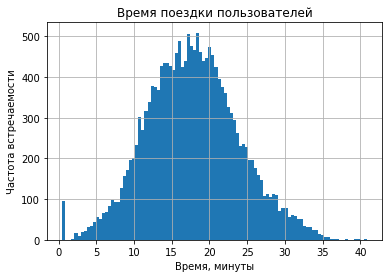

In [28]:
rides['duration'].hist(bins=100)
plt.title('Время поездки пользователей')
plt.xlabel('Время, минуты')
plt.ylabel('Частота встречаемости')
plt.show()

In [29]:
rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

Среднее время поездки составляет примерно 18 минут. Распределение похоже на нормальное. Однако в районе 1 минуты присутствует аномальный выброс. Это может быть связано со случайными вызовами или ошибочными вызовами. Такие данные не будут полезны при анализе среднего времени, поэтому от них лучше избавиться. Предварительно исследуем их подробнее.

<AxesSubplot:>

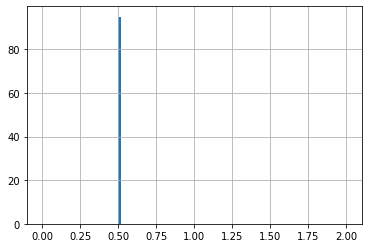

In [30]:
rides['duration'].hist(bins=100, range=(0,2))

Видно, что это одинокий пик, причём достатчоно большой. Возможно, это сбой при вызове самоката или пробная аренда. В любом случае эти данные не помогут установить среднюю длительность поездки корректно.

In [31]:
rides = rides.query('duration > 0.5')

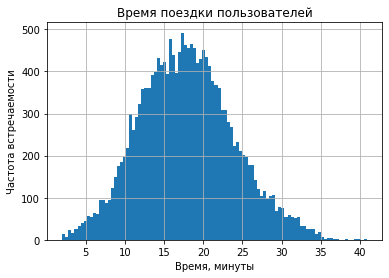

In [32]:
rides['duration'].hist(bins=100)
plt.title('Время поездки пользователей')
plt.xlabel('Время, минуты')
plt.ylabel('Частота встречаемости')
plt.show()

Эта часть данных отсечена. Теперь можно переходить к анализу

**Вывод:** Был проведен исследовательский анализ данных:
* Наиболее часто встречаемый город - Пятигорск, наимение встречаемый - Москва;
* Более половины пользователей пользуются сервисом без подписики;
* Наиболее часто встречемый возраст пользователей - 25 лет;
* Возраст, расстояние и время поездки распределены близко к нормальному;
* В распределении расстояний присутствует небольшой пик в районе 500-600 метров.

## Объединение данных

### Объединим датафреймы

In [33]:
data_merged = rides.merge(users, how = 'left', on = 'user_id' )
data_merged = data_merged.merge(subscriptions, how = 'left', on='subscription_type')
data_merged.head(10)

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199
5,1,2770.890808,16.650138,2021-10-09,10,Кира,22,Тюмень,ultra,6,0,199
6,1,3039.020292,14.927879,2021-10-19,10,Кира,22,Тюмень,ultra,6,0,199
7,1,2842.118050,23.117468,2021-11-06,11,Кира,22,Тюмень,ultra,6,0,199
8,1,3412.690668,15.238072,2021-11-14,11,Кира,22,Тюмень,ultra,6,0,199
9,1,748.690645,15.041884,2021-11-22,11,Кира,22,Тюмень,ultra,6,0,199


In [34]:
print(f'''До объединения в таблице rides было {len(rides)} строк.
В итоговой таблице стало {len(data_merged)} строк. В итоговой таблице пропусков: \n{data_merged.isna().sum()}''')

До объединения в таблице rides было 17973 строк.
В итоговой таблице стало 17973 строк. В итоговой таблице пропусков: 
user_id              0
distance             0
duration             0
date                 0
month                0
name                 0
age                  0
city                 0
subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64


Было успешно проведено объединение таблиц в одну большую. Количество строк сохранено, пропусков после слияния не обнаружено.
Теперь можно сравнить пользователей по городам и подпискам

### Выделить датафреймы с пользователями с подпиской и без

In [35]:
data_free = data_merged.query('subscription_type == "free"').reset_index(drop=True)
data_free.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,700,2515.690719,14.944286,2021-01-02,1,Айдар,22,Омск,free,8,50,0
1,700,846.932642,16.234663,2021-02-01,2,Айдар,22,Омск,free,8,50,0
2,700,4004.434142,20.016628,2021-02-04,2,Айдар,22,Омск,free,8,50,0
3,700,1205.911290,9.782872,2021-02-10,2,Айдар,22,Омск,free,8,50,0
4,700,3047.379435,17.427673,2021-02-14,2,Айдар,22,Омск,free,8,50,0


In [36]:
data_ultra = data_merged.query('subscription_type == "ultra"').reset_index(drop=True)
data_ultra.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


### Визуализировать данные о расстояниях и времени пользователей по категориям

Text(0, 0.5, 'количество пользователей')

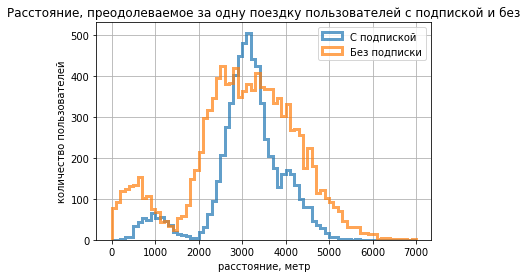

In [37]:
ax = data_ultra.plot(
    kind='hist',
    y='distance',
    histtype='step',
    range=(0, 7000),
    bins=70,
    linewidth=3,
    alpha=0.7,
    label='С подпиской',
)
data_free.plot(
    kind='hist',
    y='distance',
    histtype='step',
    range=(0, 7000),
    bins=70,
    linewidth=3,
    alpha=0.7,
    label='Без подписки',
    ax=ax,
    grid=True,
    legend=True,
) 
plt.title('Расстояние, преодолеваемое за одну поездку пользователей с подпиской и без')
plt.xlabel('расстояние, метр')
plt.ylabel('количество пользователей')

Text(0, 0.5, 'количество пользователей')

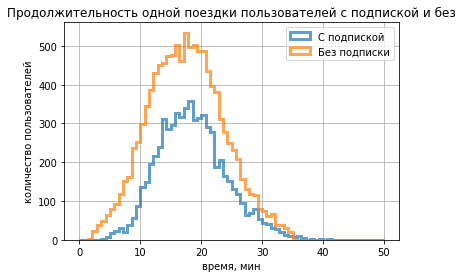

In [38]:
ax_time = data_ultra.plot(
    kind='hist',
    y='duration',
    histtype='step',
    range=(0, 50),
    bins=70,
    linewidth=3,
    alpha=0.7,
    label='С подпиской',
)
data_free.plot(
    kind='hist',
    y='duration',
    histtype='step',
    range=(0, 50),
    bins=70,
    linewidth=3,
    alpha=0.7,
    label='Без подписки',
    ax=ax_time,
    grid=True,
    legend=True,
) 
plt.title('Продолжительность одной поездки пользователей с подпиской и без')
plt.xlabel('время, мин')
plt.ylabel('количество пользователей')

**Вывод:** Были объединены датафреймы.
Из первичного рассмотрения можно предположить, что пользователи с подпиской и без проводят примерно одинаковое время в поездках. Распределения очень похожи.  
При этом пользователи с подпиской проезжают больше расстояния, чем без подписки. Причём смещён как основной пик, так и побочный пик. К тому же у пользователей без подписики присутствуют поездки с расстоянием 0. У пользователей без подписики нет выраженного пика на гистограмме.

## Подсчёт выручки

In [39]:
# округлим время поезки до следующего целого числа
data_merged['duration'] = np.ceil(data_merged['duration'])
data_merged['duration'] = data_merged['duration'].astype('int')

In [40]:
data_merged.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,26,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,16,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,7,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,19,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,27,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


Окргуление прошло успешно

In [41]:
pivot_table_merged = data_merged.pivot_table(index= ['user_id', 'month'], 
                                             values = ['distance', 'duration'],
                                             aggfunc = {'distance': ['count', 'sum'], 'duration': 'sum'})

In [42]:
pivot_table_merged.columns = ['monthly_count', 'monthly_distance', 'monthly_duration']

In [43]:
pivot_table_merged = pivot_table_merged.reset_index()
pivot_table_merged.head(50)

,user_id,month,monthly_count,monthly_distance,monthly_duration
0,1,1,2,7027.511294,42
1,1,4,1,754.159807,7
2,1,8,2,6723.470560,46
3,1,10,2,5809.911100,32
4,1,11,3,7003.499363,56
5,1,12,2,6751.629942,28
6,2,3,3,10187.723006,63
7,2,4,2,6164.381824,40
8,2,6,1,3255.338202,14
9,2,7,2,6780.722964,48


Теперь объединим эту таблицу с данными о пользователях и их подписках.

In [44]:
monthly_merged = pivot_table_merged.merge(users, how = 'left', on = 'user_id' )
monthly_merged = monthly_merged.merge(subscriptions, how = 'left', on='subscription_type')
monthly_merged.head(10)

,user_id,month,monthly_count,monthly_distance,monthly_duration,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,1,2,7027.511294,42,Кира,22,Тюмень,ultra,6,0,199
1,1,4,1,754.159807,7,Кира,22,Тюмень,ultra,6,0,199
2,1,8,2,6723.470560,46,Кира,22,Тюмень,ultra,6,0,199
3,1,10,2,5809.911100,32,Кира,22,Тюмень,ultra,6,0,199
4,1,11,3,7003.499363,56,Кира,22,Тюмень,ultra,6,0,199
5,1,12,2,6751.629942,28,Кира,22,Тюмень,ultra,6,0,199
6,2,3,3,10187.723006,63,Станислав,31,Омск,ultra,6,0,199
7,2,4,2,6164.381824,40,Станислав,31,Омск,ultra,6,0,199
8,2,6,1,3255.338202,14,Станислав,31,Омск,ultra,6,0,199
9,2,7,2,6780.722964,48,Станислав,31,Омск,ultra,6,0,199


In [45]:
monthly_merged['revenue'] = (monthly_merged['subscription_fee'] + 
                             monthly_merged['minute_price'] * monthly_merged['monthly_duration'] +
                            monthly_merged['start_ride_price'] * monthly_merged['monthly_count'])

In [46]:
monthly_merged.head()

,user_id,month,monthly_count,monthly_distance,monthly_duration,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,revenue
0,1,1,2,7027.511294,42,Кира,22,Тюмень,ultra,6,0,199,451
1,1,4,1,754.159807,7,Кира,22,Тюмень,ultra,6,0,199,241
2,1,8,2,6723.470560,46,Кира,22,Тюмень,ultra,6,0,199,475
3,1,10,2,5809.911100,32,Кира,22,Тюмень,ultra,6,0,199,391
4,1,11,3,7003.499363,56,Кира,22,Тюмень,ultra,6,0,199,535


Новый столбец посчитан корректно. Теперь на основе этих данных можно делать выводы о тратах пользователей и их поведении в зваисимости от категории

**Вывод:** на основе объединенного датасета была сформирован столбец с ежемесячными доходами от каждого пользователя.

## Проверка гипотез

Зададимся уровнем статистической значимости в 1%.

In [47]:
alpha = 0.01

### Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. 

Необходимо сравнить средние двух выборок и понять, достаточен ли уровень *p-value*. Для этого применим метод ttest_ind для сравнения двух независимых выборок

Выдвинем гипотезы. Альтернативная гипотеза будет формулироваться как правосторонняя.  
$H_0:$ Средние значения длительности поездок пользователей с подпиской и без подписки равны.  
$H_1:$ Среднее значение длительности поездок пользователей с подпиской больше, чем среднее значение у пользователей без подписок

In [48]:
#выборка пользователей без подписики
free_subs_dur = data_free['duration'] 

#выборка пользователей с подпиской
ultra_subs_dur = data_ultra['duration']

print('Среднее значение длительности поездок с подпиской: ', ultra_subs_dur.mean())
print('Среднее значение длительности поездок без подписки: ', free_subs_dur.mean())

results = st.ttest_ind(ultra_subs_dur, free_subs_dur, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

Среднее значение длительности поездок с подпиской:  18.54198516280583
Среднее значение длительности поездок без подписки:  17.530771268800226
p-значение: 4.704468074453899e-28
Отвергаем нулевую гипотезу


Нулевая гипотеза отвергается. Принимаем альтернативную гипотезу. P-value слишком мал, а значит, вероятность ошибки первого рода минимальна.
Действительно, пользователи с подпиской проводят более длительные поездки

### Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 

Необходимо сравнить среднее значение расстояния, проходимого пользователем с подпиской, с 3130 метрами. Альтернативная гипотеза будет левосторонняя. Используем метод ttest_1samp

Выдвинем гипотезы.  
$H_0:$ Среднее значение проходимого расстояния пользователями с подпиской равно 3130 метров.  
$H_1:$ Среднее значение проходимого расстояния пользователями с подпиской больше, чем 3130 метров.

In [49]:
ultra_sub_dist = data_ultra['distance']

interested_value = 3130

results = st.ttest_1samp(ultra_sub_dist, interested_value, alternative='greater')

print('Среднее значение расстояния пользователей с подпиской: ', ultra_sub_dist.mean())

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

Среднее значение расстояния пользователей с подпиской:  3115.4453880370247
p-значение:  0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


Значит, что пользователи проезжают расстояние оптимальное или меньше.

### Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 

Необходимо сравнить среднее значение выручек двух выборок: пользователей с подпиской и пользователей без подписки. Воспользуемся функцией *ttest_ind*, так как выборки независимые. Воспользуемся правосторонней альтернативной гипотезой.

Выдвинем гипотезы.  
$H_0:$ Средние значения ежемесячного дохода пользователей с подпиской и без подписки равны.  
$H_1:$ Среднее значение ежемесячного дохода пользователей с подпиской больше, чем среднее значение у пользователей без подписок

In [50]:
ultra_sub_rev = monthly_merged.query('subscription_type == "ultra"')['revenue']
free_sub_rev = monthly_merged.query('subscription_type == "free"')['revenue']

print('Среднее значение ежемесячного дохода от пользователей с подпиской: ', ultra_sub_rev.mean())
print('Среднее значение ежемесячного дохода от пользователей без подписки: ', free_sub_rev.mean())

results = st.ttest_ind(ultra_sub_rev, free_sub_rev, alternative='greater')

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

Среднее значение ежемесячного дохода от пользователей с подпиской:  362.7921906022502
Среднее значение ежемесячного дохода от пользователей без подписки:  329.3326437121324
p-значение:  2.0314113674863288e-30
Отвергаем нулевую гипотезу


Нулевая гипотеза отвергается, то есть можно предположить, что пользователи с подпиской приносят большую помесячную выручку с человека.

### Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

В этом случае сравниваются две выборки: количество обращений от пользователя до обноваления и после. То есть выборки зависимы. Необходимо использовать функцию для сравнения двух зависимых выборок *ttest_rel*.  
Важно отметить, что количество пользователей в одной и в другой выборке должно быть одинаково, а записанные значения для каждого пользователя должны находиться на соответствующих местах.

**Вывод:**
* Пользователи с подпиской в среднем проводят более длительные поездки по сравнению с пользователям без подписки (18,5 минут против 17,5 минут);
* Пользователи с подпиской в среднем приносят больший ежемесячный доход по сравнению с пользователями без подписки (362,79 рубля против 329,33 рублей;
* Пользователи с подпиской в среднем проезжают расстояния равные оптимальному расстоянию в 3130 метров.

Из этого всего можно сделать вывод, что привлечение пользователей в подписку оправдано, так как они проводят более длительные поездки и приносят больше прибыли.

## Распределения

### Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж.  
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10% пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

Задача решается использованием биноминального распределения. В этом случае успехом считается продление подписки после пробного периода, а неудачей - не продление. Вероятность успеха $p=0{,}1$. Необходимо подобрать такое количество испытаний $N$ (раздач промокодов), чтобы по итогу  вероятность 100 успешных исходов (продлений подписки) была не менее 5%.

Минимальное необходимое число промокодов:  1172
Вероятность значений 100 и менее - 4.954795210203071 %


/opt/conda/lib/python3.9/site-packages/scipy/stats/_discrete_distns.py:78: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


[]

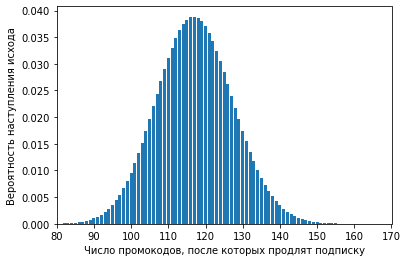

In [53]:
p = 0.1
k_interested = 100 #необходимое число успехов
n = 500 # начальное число испытаний
min_prob = 0.05 # минимальная вероятность наступления минимального числа успехов

distr = []

while binom.cdf(k_interested, n, p) > min_prob: # подбор коэффициента
    n += 1

print('Минимальное необходимое число промокодов: ', n)    

for k in range(0, n + 1):
    current_value = st.binom.pmf(k, n, p)
    distr.append(current_value)

print('Вероятность значений 100 и менее -', binom.cdf(k_interested, n, p) * 100,'%')    
    
plt.bar(range(0, n + 1), distr)
plt.xlim([80, 170])
plt.xlabel('Число промокодов, после которых продлят подписку')
plt.ylabel('Вероятность наступления исхода')
plt.plot()

**Вывод:** необходимо сделать 1172 промокода, тогда минимум 100 человек продлят подписку с вероятностью 4,95%

### Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

В этом случае эксперимент описывается биноминальным распределением с параметрами $n=1 000 000$, $p=0{,}4$, однако в силу количества испытаний можно аппроксимировать биноминальное распределение нормальным с параметрами: $\mu = n \cdot p = 400 000$, $\sigma = \sqrt{n \cdot p \cdot (1 - p)} = 489{,}898$.

Вероятность того, что пуш уведомления откроют 399500 пользователей и менее равна 15.37%


[]

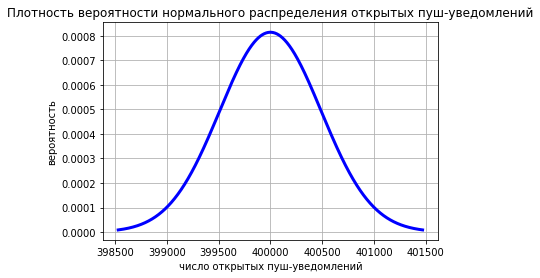

In [54]:
def linspace(start, stop, num):
    step = (stop - start) / (num - 1)
    result = []
    for i in range(num):
        result.append(start + step * i)
    return result

#параметры биноминального распредления
p = 0.4
n = 1e6

#параметры аппроксимирующего нормального распредления
mu = n * p
sigma = (n * p * (1 - p)) ** 0.5

pushes = 399500

distrib_approx = st.norm(mu, sigma) #задаём нормальное распредление с указанными параметрами

print(f'Вероятность того, что пуш уведомления откроют {pushes} пользователей и менее равна {round(distrib_approx.cdf(pushes)*100,2)}%')
x = linspace(mu - 3 * sigma, mu + 3 * sigma, 1000)
plt.plot(x, distrib_approx.pdf(x), 'b-', lw=3)
plt.title('Плотность вероятности нормального распределения открытых пуш-уведомлений')
plt.xlabel('число открытых пуш-уведомлений')
plt.ylabel('вероятность')
plt.grid()
plt.plot()






**Вывод:** 399,5 тысяч пользователей и менее откроют пуш-уведомление в 15,37% случаев. Это достаточно неплохой результат.  
Наиболее вероятное значение - примерно 400 тысяч открытых уведомлений. Проводимая акция целесообразна.

# Вывод

В ходе работы была проанализирована выборка пользователей сервиса аренды самокатов *GoFast*.  
Были выполнены в процессе предобработки: 
* Выгрузка данных;
* Поиск пропущенных значений и их заполнение;
* Удаление дубликатов.

Также на этом этапе был добавлен столбец *month* с номером месяца, в который была совершена поездка.
После этого было проведено объединение таблиц с данными для удобства анализа. В процессе был добавлен столбец с ежемесячной прибылью от пользователя.

В ходе исследовательского анализа было выявлено:
* Более половины пользователей (54,4%) пользуются сервисом без подписки;
* Больше всего пользователей находятся в Пятигорске, меньше всего - в Москве;
* Наиболее распространенное расстояние, проезжаемое за поездку, находится в районе 3 км. Большая часть поездок находится в диапазоне от 2,5 км до 3,8 км;
* Среднее время в дороге составляет примерно 18 минут.

Также после объединения данных были проанализированы группы пользователей с подпиской и без неё:
* Пользователи с подпиской проезжают больше расстояния, чем без подписки. У пользователей без подписики нет выраженного пика на гистограмме;
* Время в дороге у разных групп пользователей имеет похожее распределение, однако присутсвуют явные выбросы в районе 0,5 минут.

С помощью статистического анализа были проверены гипотезы и сделаны следующие выводы (уровень статистической значимости 1%):
* Пользователи с подпиской совершают более длительные поездки (18,5 минут против 17,5 минут);
* Пользователи с подпиской совершают в среднем оптимальные поездки для износа самокатов в 3130 метров или на меньшее расстояние;
* Пользователи с подпиской в среднем приносят большую помесячную выручку с человека, нежели пользователи без подписки (362,79 рубля в месяц против 329,33 рублей в месяц).

Рекомендации: 
* Провести раздачу промокодов. При выдаче 1172 промокодов с вероятностью более 95%, как минимум, 100 человек продлят подписку;
* Разослать один миллион пуш-уведомлений с рекламной акцией для пользователей без подписки (тогда с вероятностю 85% уведомление посмотрят 399500 человек).
